In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

# %matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm #, tnrange
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense, Input, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

def get_model(BASE_MODEL):
    from keras.preprocessing.image import ImageDataGenerator
    if BASE_MODEL=='VGG16':
        from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
    elif BASE_MODEL=='VGG19':
        from keras.applications.vgg19 import VGG19 as PTModel, preprocess_input
    elif BASE_MODEL=='RESNET52':
        from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
    elif BASE_MODEL=='InceptionV3':
        from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
    elif BASE_MODEL=='Xception':
        from keras.applications.xception import Xception as PTModel, preprocess_input
    elif BASE_MODEL=='DenseNet169': 
        from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
    elif BASE_MODEL=='DenseNet121':
        from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
    elif BASE_MODEL=='InceptionResNetV2':
        from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel, preprocess_input
    else:
        raise ValueError('Unknown model: {}'.format(BASE_MODEL))
        
    return PTModel, preprocess_input

In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=False)) for idx in tqdm(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
train_df['hassalt'] = train_df['masks'].apply(lambda x: (x.max()!=0) * 1)

  0%|          | 0/4000 [00:00<?, ?it/s]/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 4000/4000 [00:01<00:00, 2322.77it/s]


In [4]:
def get_splits(train_df, train_idx, val_idx):
    X_train = train_df.iloc[train_idx]
    X_valid = train_df.iloc[val_idx]
    x_train = np.array(X_train.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3)
    x_valid = np.array(X_valid.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3)
    msk_train = np.array(X_train.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    msk_val = np.array(X_valid.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = X_train.hassalt.values
    y_valid = X_valid.hassalt.values
    id_train = X_train.index.values
    id_valid = X_valid.index.values
    return x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid

def train_classifier(fold, model_name, x_train, y_train, x_valid, y_valid, id_valid):
    print(model_name)
    x_train_act = x_train
    x_val_act = x_valid

    inputshape = x_train_act.shape[1:]
    PTModel, preprocess_input = get_model(model_name)
    base_pretrained_model = PTModel(input_shape = inputshape, 
                                  include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False

    from keras import models, layers
    from keras.optimizers import Adam
    img_in = layers.Input(inputshape, name='Image_RGB_In')
    x = base_pretrained_model(img_in)
    x = layers.Flatten(name='flatten')(x)

    x = Dense(256)(x)
    x = BatchActivate(x)
    x = Dropout(0.5)(x)

    x = Dense(64)(x)
    x = BatchActivate(x)
    x = Dropout(0.5)(x)

    out_layer = layers.Dense(1, activation = 'sigmoid')(x)
    class_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

    class_model.compile(optimizer = Adam(lr=0.01), 
                       loss = 'binary_crossentropy',
                       metrics = ['binary_accuracy'])

    batch_size = 32
    base_name = '{}_{}'.format(model_name, fold)
    save_model_name = '../model/classifier/{}.model'.format(base_name)
    submission_file = '../result/classifier/{}.csv'.format(base_name)
    oof_file = '../result/classifier/{}_oof.csv'.format(base_name)

    print(save_model_name)
    print(submission_file)
    print(oof_file)
    
    board = keras.callbacks.TensorBoard(log_dir='log/classifier/{}'.format(base_name),
                           histogram_freq=0, write_graph=True, write_images=False)
    early_stopping = EarlyStopping(monitor='val_binary_accuracy', mode = 'max',patience=5, verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_binary_accuracy', 
                                       mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', mode = 'max',factor=0.5, patience=2, min_lr=0.00001, verbose=1)

    epochs = 200

    history = class_model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[board, early_stopping, reduce_lr, model_checkpoint],
                        verbose=1)
    
    model = load_model(save_model_name)
    
    oof = model.predict(x_valid)
    df_oof = pd.DataFrame()
    df_oof['id'] = id_valid
    df_oof['target'] = oof
    df_oof.to_csv(oof_file, index=False)
    
    files = os.listdir('../input/test/images/')
    x_test = np.array([(np.array(load_img("../input/test/images/{}".format(idx), grayscale = False))) for idx in files]).reshape(-1, img_size_target, img_size_target, 3)
    preds_test = model.predict(x_test)
    df_result = pd.DataFrame()
    df_result['id'] = files
    df_result['pre'] = preds_test.reshape(len(files))
    df_result.to_csv(submission_file, index=False)


In [8]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = False))) for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 3)


In [9]:
oofs = []
vals = []
pre_tests = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['hassalt'])):
    x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid = get_splits(train_df, train_idx, val_idx)
    print('fold', fold)
    
    batch_size = 32
    base_name = '{}_{}'.format('VGG16', fold)
    save_model_name = '../model/classifier/{}.model'.format(base_name)
    submission_file = '../result/classifier/{}.csv'.format(base_name)
    oof_file = '../result/classifier/{}_oof.csv'.format(base_name)
    
    model = load_model(save_model_name)
    oof = model.predict(x_valid)
    
    oofs.append(oof)
    vals.append(y_valid)
    
    pre_test = model.predict(x_test)
    pre_tests.append(pre_test)
    
    from keras import backend as K
    K.clear_session()
    
    

/home/kownse/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [10]:
oof_all = np.concatenate(oofs, axis=0)
val_all = np.concatenate(vals, axis= 0)

In [12]:
val_all.shape

(4000,)

In [13]:
thresholds = np.linspace(0.2, 0.8, 50)

ious = np.array([iou_metric_batch(val_all, oof_all > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.864   0.8665  0.868   0.8695  0.871   0.87275 0.8745  0.87575 0.878
 0.88075 0.88225 0.883   0.88425 0.88625 0.8875  0.8885  0.8905  0.892
 0.892   0.892   0.89375 0.8945  0.89575 0.8965  0.8975  0.8975  0.8955
 0.893   0.89275 0.89275 0.892   0.8905  0.888   0.8875  0.8855  0.88475
 0.8845  0.883   0.88125 0.8805  0.88    0.87875 0.878   0.877   0.8755
 0.87375 0.87275 0.8705  0.8705  0.86775]


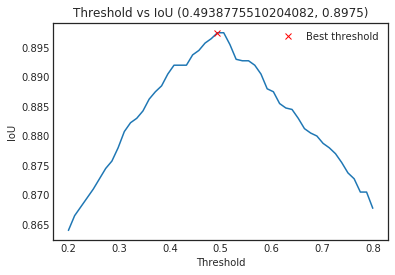

In [14]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [15]:
threshold_best

0.4938775510204082

In [16]:
pred_tests_act = pre_tests
pred_test_all = np.zeros_like(pred_tests_act[0], dtype=np.float32)
for pre in pred_tests_act:
    pred_test_all += pre / len(pred_tests_act)

In [18]:
pred_test_all.shape

(18000, 1)

In [22]:
pre_final = (pred_test_all > threshold_best) * 1

In [23]:
np.save('../result/class_res.npy', pre_final)